# Explore candidates matched to stars

The problem with doing anything with stars is that

1. we only have difference-image fluxes, not direct-image fluxes and

2. we only have difference-image detections when the difference-image flux is positive.

So the "light curve" is only for epochs when the star was brighter that it was in the template image.

We do have the static-sky matches and they have a magnitude, but whether that can be considered
a mean magnitude is unclear...

We could, however, just look at stars that are significantly brighter in the difference images...


Other thoughts of things we could do with stars for a section of the paper.

 * Plot a histogram of the light curve time span for candidates matched to stars. Is it bimodal? I.e., flares and variables?

 * How many potential stars have light curves that can be fit with a periodigram?

 * Explore the distributions of derived periods. What are most of these potential stars?

## Set up

Import packages and define plotting parameters.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle

In [2]:
all_filters = np.asarray(['g','r','i'], dtype='str')
all_fcolors = np.asarray(['green','red','blue'], dtype='str')
all_fshapes = np.asarray(['o','s','^'], dtype='str')
all_fsizes  = np.asarray([5, 5, 7], dtype='int')

Read in the nightly-epoch light curves and their measured parameters.

In [3]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

In [4]:
fnm = '../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
paramLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
paramLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
paramLC_tspan = np.loadtxt(fnm, dtype='float', usecols=(2))
paramLC_tspan_g = np.loadtxt(fnm, dtype='float', usecols=(3))
paramLC_tspan_r = np.loadtxt(fnm, dtype='float', usecols=(4))
paramLC_tspan_i = np.loadtxt(fnm, dtype='float', usecols=(5))
paramLC_minmag = np.loadtxt(fnm, dtype='float', usecols=(6))
paramLC_minmag_g = np.loadtxt(fnm, dtype='float', usecols=(7))
paramLC_minmag_r = np.loadtxt(fnm, dtype='float', usecols=(8))
paramLC_minmag_i = np.loadtxt(fnm, dtype='float', usecols=(9))
paramLC_amp = np.loadtxt(fnm, dtype='float', usecols=(10))
paramLC_amp_g = np.loadtxt(fnm, dtype='float', usecols=(11))
paramLC_amp_r = np.loadtxt(fnm, dtype='float', usecols=(12))
paramLC_amp_i = np.loadtxt(fnm, dtype='float', usecols=(13))
paramLC_neps = np.loadtxt(fnm, dtype='int', usecols=(14))
paramLC_neps_g = np.loadtxt(fnm, dtype='int', usecols=(15))
paramLC_neps_r = np.loadtxt(fnm, dtype='int', usecols=(16))
paramLC_neps_i = np.loadtxt(fnm, dtype='int', usecols=(17))
del fnm

Nightly-epoch magnitude limits, so we have a list of all epochs.

In [5]:
fnm = '../all_nightly_epochs_files/nightly_epoch_magnitude_limits.dat'
neml_field = np.loadtxt(fnm, dtype='str', usecols=(0))
neml_caldate = np.loadtxt(fnm, dtype='str', usecols=(1))
neml_mjd = np.loadtxt(fnm, dtype='float', usecols=(2))
neml_filter = np.loadtxt(fnm, dtype='str', usecols=(3))
neml_nimgs = np.loadtxt(fnm, dtype='int', usecols=(4))
neml_limmag = np.loadtxt(fnm, dtype='float', usecols=(5))
neml_limmage = np.loadtxt(fnm, dtype='float', usecols=(6))
del fnm

In [6]:
for field in ['COSMOS', 'ELAIS']:
    gx = np.where((neml_field == field) & (neml_filter == 'g'))[0]
    rx = np.where((neml_field == field) & (neml_filter == 'r'))[0]
    ix = np.where((neml_field == field) & (neml_filter == 'i'))[0]
    print(len(gx), len(rx), len(ix))
    del gx, rx, ix

82 82 86
98 98 97


Read in all rows of the cross-matched file.

`flagstar` : 1 if matched to a star; 0 if matched to a galaxy; -1 if unmatched (int) 

`flagcore` : 1 if matched to the core of the galaxy; 0 otherwise (int) 

`flagmatch` : 1 if a star AND galaxy met constraints; 0 if one or the other; -1 if unmatched (int) 

In [7]:
fnm = '../cross_matched_LSDR10/candidate_xmatch_LSdr10.dat'
lsdr10xm_candid   = np.loadtxt(fnm, dtype='str', usecols=(0))
lsdr10xm_candra   = np.loadtxt(fnm, dtype='float', usecols=(1))
lsdr10xm_canddec  = np.loadtxt(fnm, dtype='float', usecols=(2))
lsdr10xm_flagstar = np.loadtxt(fnm, dtype='int', usecols=(4))
lsdr10xm_flagcore = np.loadtxt(fnm, dtype='int', usecols=(5))
lsdr10xm_flagmatch= np.loadtxt(fnm, dtype='int', usecols=(6))
lsdr10xm_sep      = np.loadtxt(fnm, dtype='float', usecols=(7))
lsdr10xm_ra       = np.loadtxt(fnm, dtype='float', usecols=(8))
lsdr10xm_dec      = np.loadtxt(fnm, dtype='float', usecols=(9))
lsdr10xm_rmag     = np.loadtxt(fnm, dtype='float', usecols=(13))
lsdr10xm_type     = np.loadtxt(fnm, dtype='str', usecols=(15))
lsdr10xm_shaper   = np.loadtxt(fnm, dtype='float', usecols=(19))
lsdr10xm_rpsfsize = np.loadtxt(fnm, dtype='float', usecols=(21))  
lsdr10xm_meanpz   = np.loadtxt(fnm, dtype='float', usecols=(23))
lsdr10xm_stdpz    = np.loadtxt(fnm, dtype='float', usecols=(24))
lsdr10xm_specz    = np.loadtxt(fnm, dtype='float', usecols=(25))
del fnm

Cross-match between the `lsdr10xm_` arrays and `paramLC_` arrays.

In [8]:
paramLC_xindex = np.zeros(len(paramLC_candid), dtype='int') - 1
lsdr10xm_pindex = np.zeros(len(lsdr10xm_candid), dtype='int') -1

for px in range(len(paramLC_candid)):
    tx = np.where(paramLC_candid[px] == lsdr10xm_candid)[0]
    if len(tx) == 1:
        paramLC_xindex[px] = tx[0]
        lsdr10xm_pindex[tx[0]] = px
    else:
        print(paramLC_candid[px], len(tx))
    del tx
del px

Reminder of how many candidates are matched to stars vs. galaxies.

In [9]:
sx = np.where(lsdr10xm_flagstar == 1)[0]
gx = np.where(lsdr10xm_flagstar == 0)[0]
print('Number of candidates matched to:')
print('stars: ', len(sx))
print('galaxies: ', len(gx))
del sx, gx

Number of candidates matched to:
stars:  6290
galaxies:  2587


Plot the static-sky r-band magnitudes.

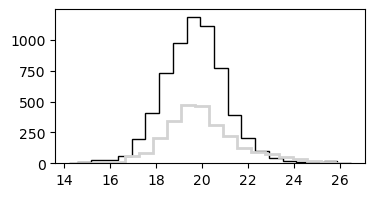

In [10]:
plt.figure(figsize=(4, 2))
sx = np.where(lsdr10xm_flagstar == 1)[0]
gx = np.where(lsdr10xm_flagstar == 0)[0]
plt.hist(lsdr10xm_rmag[sx], bins=20, lw=1, histtype='step', color='black', label='stars')
plt.hist(lsdr10xm_rmag[gx], bins=20, lw=2, histtype='step', color='lightgrey', label='galaxies')
plt.show()

## Illustrate the light curve parameters for candidates matched to stars

Histograms of the light curve parameters for candidates matched to stars and galaxies.

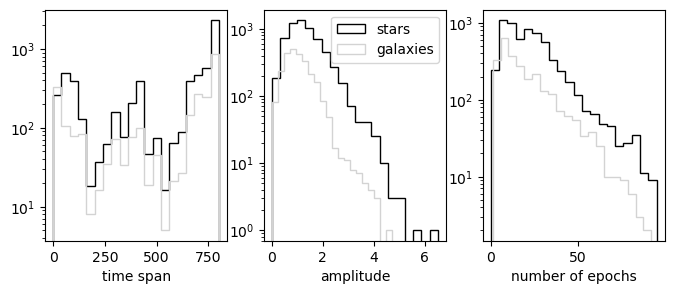

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharex=False, sharey=False)

# ax[0].hist(paramLC_tspan, bins=20, log=True, histtype='step', color='grey', label='all')
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
ax[0].hist(paramLC_tspan[px], bins=20, log=True, histtype='step', color='black', label='stars')
del tx, px
tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
ax[0].hist(paramLC_tspan[px], bins=20, log=True, histtype='step', color='lightgrey', label='galaxies')
del tx, px
ax[0].set_xlabel('time span')

# ax[1].hist(paramLC_amp, bins=20, log=True, histtype='step', color='grey', label='all')
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
ax[1].hist(paramLC_amp[px], bins=20, log=True, histtype='step', color='black', label='stars')
del tx, px
tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
ax[1].hist(paramLC_amp[px], bins=20, log=True, histtype='step', color='lightgrey', label='galaxies')
del tx, px
ax[1].set_xlabel('amplitude')
ax[1].legend(loc='best')

# ax[2].hist(paramLC_neps, bins=20, log=True, histtype='step', color='grey', label='all')
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
ax[2].hist(paramLC_neps[px], bins=20, log=True, histtype='step', color='black', label='stars')
del tx, px
tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
ax[2].hist(paramLC_neps[px], bins=20, log=True, histtype='step', color='lightgrey', label='galaxies')
del tx, px
ax[2].set_xlabel('number of epochs')

plt.show()

Scatter plots of light curve parameters.

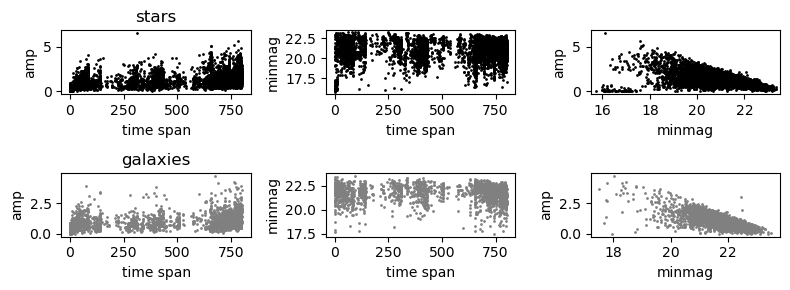

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(8, 3), sharex=False, sharey=False)

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
ax[0, 0].plot(paramLC_tspan[px], paramLC_amp[px], 'o', ms=2, mew=0, color='black', label='stars')
del tx, px
tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
ax[1, 0].plot(paramLC_tspan[px], paramLC_amp[px], 'o', ms=2, mew=0, color='grey', label='galaxies')
del tx, px
ax[0, 0].set_xlabel('time span')
ax[0, 0].set_ylabel('amp')
ax[1, 0].set_xlabel('time span')
ax[1, 0].set_ylabel('amp')
ax[0, 0].set_title('stars')
ax[1, 0].set_title('galaxies')

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
ax[0, 1].plot(paramLC_tspan[px], paramLC_minmag[px], 'o', ms=2, mew=0, color='black', label='stars')
del tx, px
tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
ax[1, 1].plot(paramLC_tspan[px], paramLC_minmag[px], 'o', ms=2, mew=0, color='grey', label='galaxies')
del tx, px
ax[0, 1].set_xlabel('time span')
ax[0, 1].set_ylabel('minmag')
ax[0, 1].set_ylim([15.5, 23.5])
ax[1, 1].set_xlabel('time span')
ax[1, 1].set_ylabel('minmag')

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
ax[0, 2].plot(paramLC_minmag[px], paramLC_amp[px], 'o', ms=2, mew=0, color='black', label='stars')
del tx, px
tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
ax[1, 2].plot(paramLC_minmag[px], paramLC_amp[px], 'o', ms=2, mew=0, color='grey', label='galaxies')
del tx, px
ax[0, 2].set_xlabel('minmag')
ax[0, 2].set_xlim([15.5, 23.5])
ax[0, 2].set_ylabel('amp')
ax[1, 2].set_xlabel('minmag')
ax[1, 2].set_ylabel('amp')

plt.tight_layout()
plt.show()

Compare the r-band difference-image photometry with the r-band static sky magnitudes.

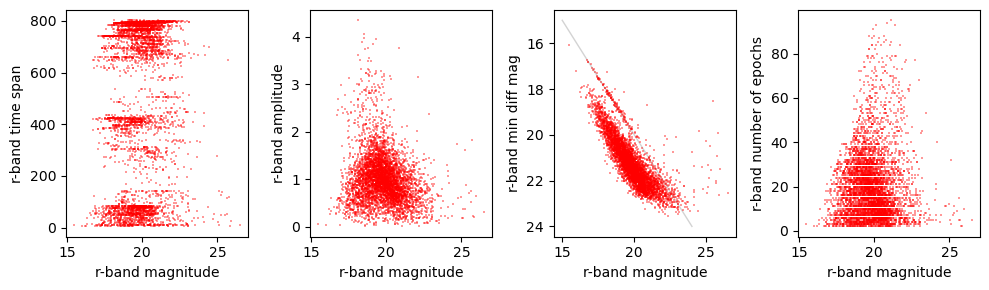

In [13]:
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
del tx

tx = np.where((paramLC_minmag_r[px] > 0.0) & (paramLC_tspan_r[px] > 5.0))[0]
rx = px[tx]
del tx, px

xx = paramLC_xindex[rx]

fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharex=False, sharey=False)

ax[0].plot(lsdr10xm_rmag[xx], paramLC_tspan_r[rx], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[0].set_xlabel('r-band magnitude')
ax[0].set_ylabel('r-band time span')

ax[1].plot(lsdr10xm_rmag[xx], paramLC_amp_r[rx], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[1].set_xlabel('r-band magnitude')
ax[1].set_ylabel('r-band amplitude')

ax[2].plot([15, 24], [15, 24], lw=1, color='lightgrey')
ax[2].plot(lsdr10xm_rmag[xx], paramLC_minmag_r[rx], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[2].set_xlabel('r-band magnitude')
ax[2].set_ylabel('r-band min diff mag')
ax[2].invert_yaxis()

ax[3].plot(lsdr10xm_rmag[xx], paramLC_neps_r[rx], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[3].set_xlabel('r-band magnitude')
ax[3].set_ylabel('r-band number of epochs')

plt.tight_layout()
plt.show()

del rx, xx

### Odd locus of $MAX(m_t) = m_{ref} - 0.75$ candidates

What are these objects in the third panel where the brightest difference-image magnitude is equal to the static-sky magnitude?

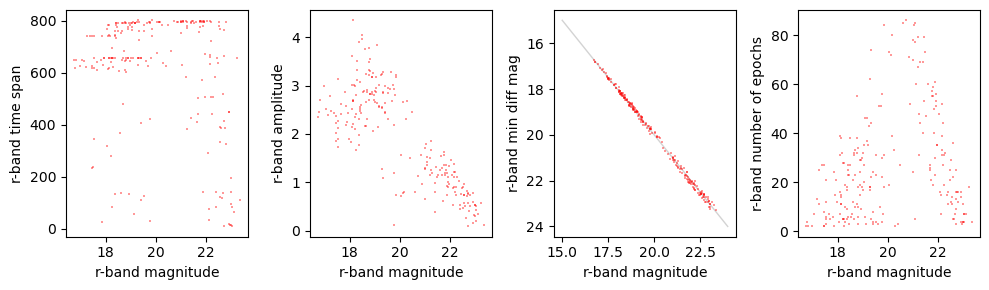

In [14]:
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
del tx

tx = np.where((paramLC_minmag_r[px] > 0.0) & (paramLC_tspan_r[px] > 5.0))[0]
rx = px[tx]
del tx, px

xx = paramLC_xindex[rx]

temp = np.abs(lsdr10xm_rmag[xx] - paramLC_minmag_r[rx])
ix = np.where(temp < 0.2)[0]

fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharex=False, sharey=False)

ax[0].plot(lsdr10xm_rmag[xx[ix]], paramLC_tspan_r[rx[ix]], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[0].set_xlabel('r-band magnitude')
ax[0].set_ylabel('r-band time span')

ax[1].plot(lsdr10xm_rmag[xx[ix]], paramLC_amp_r[rx[ix]], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[1].set_xlabel('r-band magnitude')
ax[1].set_ylabel('r-band amplitude')

ax[2].plot([15, 24], [15, 24], lw=1, color='lightgrey')
ax[2].plot(lsdr10xm_rmag[xx[ix]], paramLC_minmag_r[rx[ix]], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[2].set_xlabel('r-band magnitude')
ax[2].set_ylabel('r-band min diff mag')
ax[2].invert_yaxis()

ax[3].plot(lsdr10xm_rmag[xx[ix]], paramLC_neps_r[rx[ix]], 's', ms=2, alpha=0.4, mew=0, color='red')
ax[3].set_xlabel('r-band magnitude')
ax[3].set_ylabel('r-band number of epochs')

plt.tight_layout()
plt.show()

del rx, xx, temp, ix

If the brightest difference-image magnitude that we observe is equal to the static-sky magnitude, then what does that indicate is happening?

Assuming the static-sky magnitude and the reference-image magnitude are the same, it means the following.

$\Delta f_t$ is the difference-image flux, the flux at time $t$ minus the flux in the reference image:
$\Delta f_t = f_t - f_{ref}$.

We see a locus of candidates for which the brightest $\Delta f_t$ is equal to $f_{ref}$.

In these brightest epochs, $f_t = 2 f_{ref}$.

Which can also be expressed as $m_t = -2.5 \log_{10}(2 f_{ref}) = m_{ref} - 0.75$.

It seems very weird and contrived that there should be a bunch of stars for which the
brightest epoch we catch is $m_t = m_{ref} - 0.75$.

The other thing that could be happening is that in our template images, the star
is extremely faint, such that our difference-image magnitudes are equivalent to
direct-image magnitudes. In this case, our brightest difference-image magnitude
could agree fine with the static-sky magnitude if the latter is representative
of its brightest magnitude also. However, a quick check of the reference images
for a few candidates in the locus reveals a clear and obvious source in the reference image.

Take a look at a random few of these light curves.

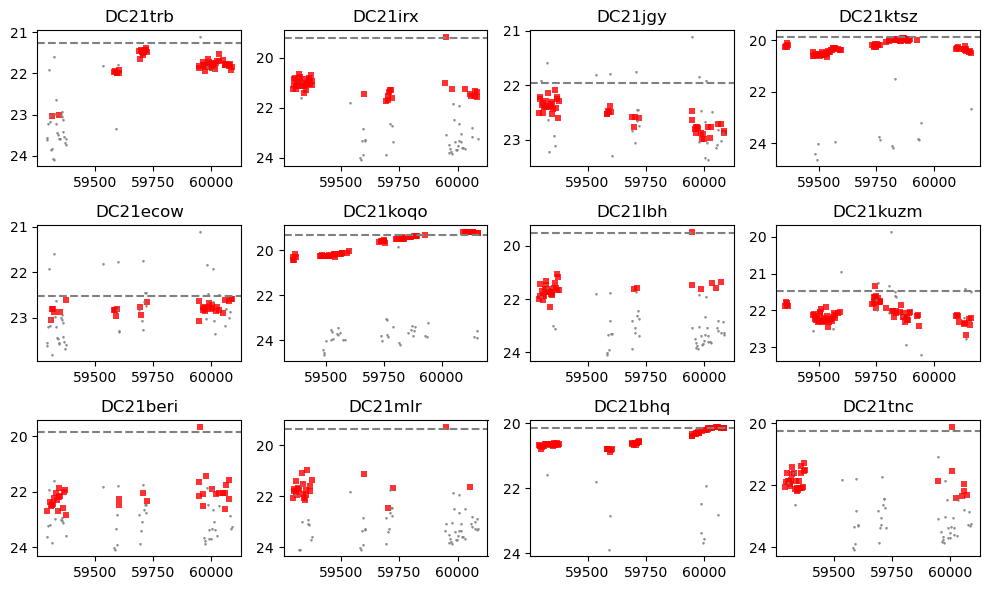

In [15]:
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
del tx

tx = np.where((paramLC_minmag_r[px] > 0.0) & (paramLC_tspan_r[px] > 750.0))[0]
rx = px[tx]
del tx, px

xx = paramLC_xindex[rx]

temp = np.abs(lsdr10xm_rmag[xx] - paramLC_minmag_r[rx])
ix = np.where(temp < 0.2)[0]

fig, ax = plt.subplots(3, 4, figsize=(10, 6), sharex=False, sharey=False)

x = np.random.choice(len(ix), 12, replace=False)

count = 0
for i in range(4):
    for j in range(3):
        cx = np.where((candLC_filter == 'r') & (candLC_candid == paramLC_candid[rx[ix[x[count]]]]))[0]
        ax[j, i].plot(candLC_mjd[cx], candLC_mag[cx], 's', ms=4, mew=0, alpha=0.8, color='red')
        
        nx = np.where((neml_filter == 'r') & (neml_field == candLC_field[cx[0]]))[0]
        for n in nx:
            tx = np.where(np.abs(neml_mjd[n] - candLC_mjd[cx]) < 0.7)[0]
            if len(tx) == 0:
                ax[j, i].plot(neml_mjd[n], neml_limmag[n], 'v', ms=1, color='grey')
            del tx
        del nx
        
        ax[j, i].invert_yaxis()
        ax[j, i].axhline(lsdr10xm_rmag[xx[ix[x[count]]]], ls='dashed', color='grey')
        ax[j, i].set_title(candLC_candid[cx[0]])
        del cx
        count += 1
del count

plt.tight_layout()
plt.show()
del rx, xx, temp, ix, x

Above, the red squares are the difference-image magnitudes (postive detections only),
the grey triangles are limiting difference-image magnitudes on epochs of non-detection, 
and the grey dashed line is the static-sky (direct-image) magnitude.

Still not sure what's up with this locus of candidates but.... let's move on.

## SKIP: Try a periodogram for a random candidate

This does not really work, though it was a learning experience.

A random candidate is going to have longer duration variability than what is attempted here.

Below, just take one random candidate with a moderate brightness and amplitude 
that has many epochs and attempt to apply a periodogram.

In [16]:
# min_rmag = 19
# max_rmag = 21
# min_amp = 0.5
# max_amp = 2.5
# min_tspan = 40
# min_neps = 60

# tx = np.where((lsdr10xm_flagstar == 1) & (lsdr10xm_rmag > min_rmag) & (lsdr10xm_rmag < max_rmag))[0]
# px = lsdr10xm_pindex[tx]
# print(len(px), ' out of ', len(lsdr10xm_flagstar), ' candidates meet the magnitude restrictions.')

# ix = np.where((paramLC_amp[px] > min_amp) & (paramLC_amp[px] < max_amp) & 
#               (paramLC_tspan[px] > min_tspan) &  (paramLC_neps[px] > min_neps))[0]
# print(len(ix), ' out of ', len(px), ' candidates meet the magnitude and light curve parameter conditions.')

# rx = np.random.choice(len(ix), 1)
# x = px[ix[rx[0]]]
# print('randomly selected candidate: ', paramLC_candid[x])
# print('rmag = ', lsdr10xm_rmag[paramLC_xindex[x]])
# print('minmag_r = ', paramLC_minmag_r[x])
# print('amp_r = ', paramLC_amp_r[x])
# cand = paramLC_candid[x]
# del tx, px, ix, rx, x
# del min_rmag, max_rmag, min_amp, max_amp, min_tspan, min_neps

Index the parameters and light curve points that belong to this candidate.

In [17]:
# xx = np.where(lsdr10xm_candid == cand)[0]
# px = np.where(paramLC_candid == cand)[0]
# cx = np.where(candLC_candid == cand)[0]

Print some parameters for this candidate.

In [18]:
# print(lsdr10xm_candid[xx[0]], lsdr10xm_rmag[xx[0]])
# print(paramLC_field[px[0]], paramLC_candid[px[0]], paramLC_minmag_r[px[0]])
# print(' ')
# print('       %6s %6s %6s %6s ' % ('all', 'g', 'r', 'i'))
# print('tspan  %6.1f %6.1f %6.1f %6.1f' % (paramLC_tspan[px[0]], paramLC_tspan_g[px[0]], paramLC_tspan_r[px[0]], paramLC_tspan_i[px[0]]))
# print('minmag %6.1f %6.1f %6.1f %6.1f' % (paramLC_minmag[px[0]], paramLC_minmag_g[px[0]], paramLC_minmag_r[px[0]], paramLC_minmag_i[px[0]]))
# print('amp    %6.1f %6.1f %6.1f %6.1f' % (paramLC_amp[px[0]], paramLC_amp_g[px[0]], paramLC_amp_r[px[0]], paramLC_amp_i[px[0]]))
# print('neps   %6i %6i %6i %6i' % (paramLC_neps[px[0]], paramLC_neps_g[px[0]], paramLC_neps_r[px[0]], paramLC_neps_i[px[0]]))

Go with filter r because we have static-sky mags for filter r.

In [19]:
# usefilt = 'r'

Plot the difference-image light curve.

In [20]:
# fx = np.where(candLC_filter[cx] == usefilt)[0]
# days = candLC_mjd[cx[fx]]
# mags = candLC_mag[cx[fx]]

# x = np.where(all_filters == usefilt)[0]
# sym = all_fshapes[x[0]]
# clr = all_fcolors[x[0]]

# plt.figure(figsize=(4, 2))
# plt.plot(days, mags, sym, ms=3, color=clr)
# plt.gca().invert_yaxis()
# plt.show()

# del x, sym, clr

For RR Lyrae the periods are ~half a day, but Cepheids can be longer, ~10 days. 

Try 0.1 days to 20 days (even if the light curve above exhibits variability over a longer timescale).

In [21]:
# min_p = 0.1 * u.day
# max_p = 20.1 * u.day
# min_f = 1.0 / max_p
# max_f = 1.0 / min_p

Do the Lomb Scargle periodogram fit.

In [22]:
# frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, maximum_frequency=max_f)

In [23]:
# tmp = np.argsort(power)
# sx = tmp[::-1]
# best_period = 1 / frequency[sx[0]].value
# print('best period: ', best_period, ' in days')
# del tmp, sx

In [24]:
# print(np.min(power), np.max(power))
# print(np.mean(power), np.std(power))
# print((np.max(power)-np.mean(power))/np.std(power))

Show the results.

Take as the best period the highest power peak.

In [25]:
# plt.figure(figsize=(8, 2))
# plt.plot(frequency, power, color='grey', lw=1)
# plt.xlabel('frequency')
# plt.show()

# plt.figure(figsize=(8, 2))
# # plt.axvline(np.log10(best_period), color='dodgerblue', lw=5, alpha=0.5)
# # plt.plot(np.log10(1 / frequency.value), power, color='grey', lw=1)
# plt.axvline(best_period, color='dodgerblue', lw=5, alpha=0.5)
# plt.plot(1 / frequency.value, power, color='grey', lw=1)
# plt.xlabel('log period [days]')
# plt.show()

Phase-fold the light curve and plot it.

In [26]:
# t0 = np.min(days)
# days_norm = (days - t0) / best_period
# phase = np.mod(days_norm, 1.0)
# del t0

# x = np.where(all_filters == usefilt)[0]
# sym = all_fshapes[x[0]]
# clr = all_fcolors[x[0]]

# plt.figure(figsize=(4, 2))
# plt.plot(phase, mags, sym, ms=3, color=clr)
# plt.xlabel('phase')
# plt.gca().invert_yaxis()
# plt.show()

The above sequence of steps usually yeilds a best-fit period of a half day or a day.

This is just aliasing. It's not real! But it was a way to test doing periodograms.

## Try periodograms for long period variables

First create arrays to hold the results.

`Pbest` will be the best period.

`Ppwr` will be the power in that period.

`Psnr` with be the 'signal-to-noise ratio' for the best period: (max(power)-mean(power)) / std(power)

In [27]:
paramLC_Pbest_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Pbest_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Pbest_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0

Set the input parameters to go after longer duration variables.

https://www.aanda.org/articles/aa/full_html/2014/06/aa23252-13/F14.html

In [28]:
min_p = 50.1 * u.day
max_p = 1000.1 * u.day
min_f = 1.0 / max_p
max_f = 1.0 / min_p

Make the periodograms for all candidates matched to stars that have sufficient time span, amplitude, and number of epochs.

In [29]:
min_tspan = 100
min_amp = 0.5
min_neps = 40

In [30]:
t1 = time.time()

for p in range(len(paramLC_candid)):

    if (p == 10) | (p == 100) | (p == 1000):
        t2 = time.time()
        print('p=%6i, %5.1f seconds remain' % (p, ((t2-t1)/float(p))*(float(len(paramLC_candid)-p))))
    
    if (lsdr10xm_flagstar[paramLC_xindex[p]] == 1) & \
    (paramLC_tspan[p] > min_tspan) & (paramLC_amp[p] > min_amp) & \
    (paramLC_neps[p] > min_neps):
        tmp1 = np.zeros(3, dtype='float')
        tmp2 = np.zeros(3, dtype='float')
        tmp3 = np.zeros(3, dtype='float')

        for f, filt in enumerate(all_filters):
            x = np.where((candLC_candid == paramLC_candid[p]) & 
                         (candLC_filter == filt))[0]

            if len(x) > 30:
                days = candLC_mjd[x]
                mags = candLC_mag[x]
                frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, 
                                                                             maximum_frequency=max_f)
                mx = np.argmax(power)
                tmp1[f] = 1 / frequency[mx].value
                tmp2[f] = (np.max(power)-np.mean(power))/np.std(power)
                tmp3[f] = np.max(power)
                del days, mags, frequency, power, mx
            del x

        paramLC_Pbest_g[p] = tmp1[0]
        paramLC_Pbest_r[p] = tmp1[1]
        paramLC_Pbest_i[p] = tmp1[2]
        paramLC_Psnr_g[p] = tmp2[0]
        paramLC_Psnr_r[p] = tmp2[1]
        paramLC_Psnr_i[p] = tmp2[2]
        paramLC_Ppwr_g[p] = tmp3[0]
        paramLC_Ppwr_r[p] = tmp3[1]
        paramLC_Ppwr_i[p] = tmp3[2]
        del tmp1, tmp2
        
t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))
del t1, t2

p=    10,   7.2 seconds remain
p=   100,   1.3 seconds remain
p=  1000,   1.3 seconds remain
elapsed:   4.5


In [31]:
gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]
print(len(gx), len(rx), len(ix))
del gx, rx, ix

379 580 178


Explore the periodogram results by plotting them.

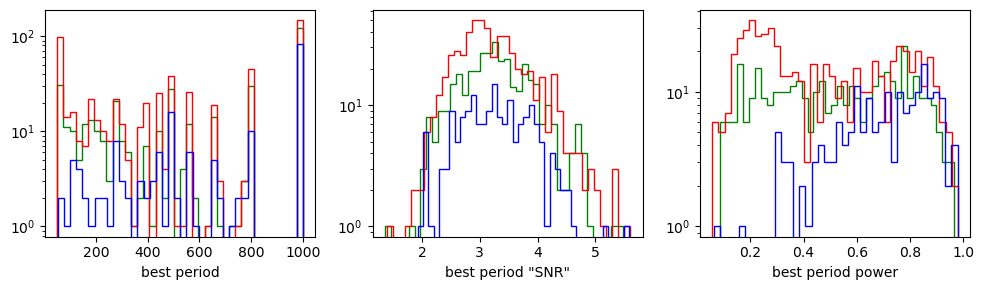

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]

ax[0].hist(paramLC_Pbest_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
ax[0].hist(paramLC_Pbest_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
ax[0].hist(paramLC_Pbest_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
ax[0].set_xlabel('best period')

ax[1].hist(paramLC_Psnr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
ax[1].hist(paramLC_Psnr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
ax[1].hist(paramLC_Psnr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
ax[1].set_xlabel('best period "SNR"')

ax[2].hist(paramLC_Ppwr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
ax[2].hist(paramLC_Ppwr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
ax[2].hist(paramLC_Ppwr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
ax[2].set_xlabel('best period power')

plt.tight_layout()
plt.show()

del gx, rx, ix

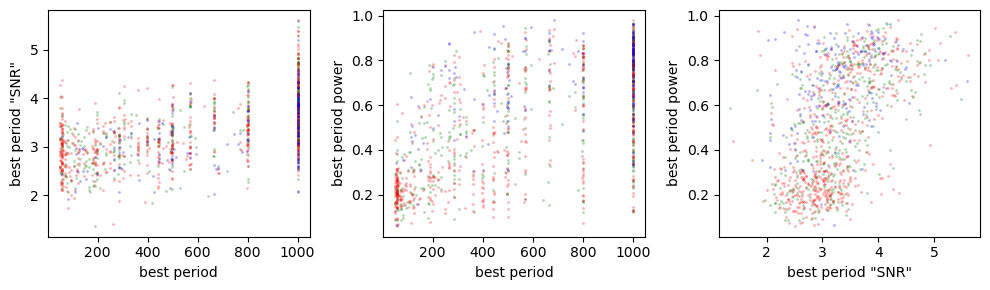

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]

ax[0].plot(paramLC_Pbest_g[gx], paramLC_Psnr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
ax[0].plot(paramLC_Pbest_r[rx], paramLC_Psnr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
ax[0].plot(paramLC_Pbest_i[ix], paramLC_Psnr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
ax[0].set_xlabel('best period')
ax[0].set_ylabel('best period "SNR"')

ax[1].plot(paramLC_Pbest_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
ax[1].plot(paramLC_Pbest_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
ax[1].plot(paramLC_Pbest_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
ax[1].set_xlabel('best period')
ax[1].set_ylabel('best period power')

ax[2].plot(paramLC_Psnr_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
ax[2].plot(paramLC_Psnr_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
ax[2].plot(paramLC_Psnr_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
ax[2].set_xlabel('best period "SNR"')
ax[2].set_ylabel('best period power')

plt.tight_layout()
plt.show()

del gx, rx, ix

How often do the results from different filters agree?

Exclude the periods >700 days because those are basically equivalent to "not periodic", 
as in, the period was the whole duration of the five semesters.

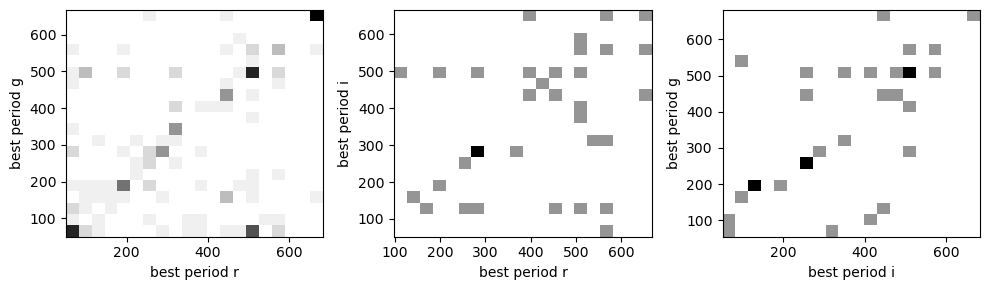

In [34]:
max_P = 700

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=False, sharey=False)

grx = np.where((paramLC_Pbest_g > 0.0) & (paramLC_Pbest_r > 0.0) & 
               (paramLC_Pbest_g < max_P) & (paramLC_Pbest_r < max_P))[0]
rix = np.where((paramLC_Pbest_r > 0.0) & (paramLC_Pbest_i > 0.0) & 
               (paramLC_Pbest_r < max_P) & (paramLC_Pbest_i < max_P))[0]
gix = np.where((paramLC_Pbest_g > 0.0) & (paramLC_Pbest_i > 0.0) & 
               (paramLC_Pbest_g < max_P) & (paramLC_Pbest_i < max_P))[0]
del max_P

ax[0].hist2d(paramLC_Pbest_r[grx], paramLC_Pbest_g[grx], bins=20, cmap='Greys')
ax[0].set_xlabel('best period r')
ax[0].set_ylabel('best period g')

ax[1].hist2d(paramLC_Pbest_r[rix], paramLC_Pbest_i[rix], bins=20, cmap='Greys')
ax[1].set_xlabel('best period r')
ax[1].set_ylabel('best period i')

ax[2].hist2d(paramLC_Pbest_i[gix], paramLC_Pbest_g[gix], bins=20, cmap='Greys')
ax[2].set_xlabel('best period i')
ax[2].set_ylabel('best period g')

plt.tight_layout()
plt.show()

del grx, rix, gix

Looks like they agree between g and r pretty often.

### Plot phase-folded light curves for periodic candidates

Check out a few of the best, with the highest snr and powers,
and periods less than the duration of the DDF to date.

In [35]:
paramLC_Pbest_diffgr = np.abs(paramLC_Pbest_g - paramLC_Pbest_r)

# min_pwr = 0.4
# min_snr = 3.5
# min_diff = 20
# max_P = 800

min_pwr = 0.4
min_snr = 3.5
min_diff = 50
max_P = 700

gx = np.where((paramLC_Ppwr_g > min_pwr) & (paramLC_Psnr_g > min_snr) 
              & (paramLC_Pbest_g < max_P))[0]
rx = np.where((paramLC_Ppwr_r > min_pwr) & (paramLC_Psnr_r > min_snr) 
              & (paramLC_Pbest_r < max_P))[0]
print('Number of candidates that have well fit best periods in g OR r: ', len(gx), len(rx))
print(paramLC_candid[rx])
del gx, rx

print(' ')

gx = np.where((paramLC_Ppwr_g > min_pwr) & (paramLC_Psnr_g > min_snr) 
              & (paramLC_Pbest_g < max_P) & (paramLC_Pbest_diffgr < min_diff))[0]
rx = np.where((paramLC_Ppwr_r > min_pwr) & (paramLC_Psnr_r > min_snr) 
              & (paramLC_Pbest_r < max_P) & (paramLC_Pbest_diffgr < min_diff))[0]
print('Number of candidates that have well fit periods in g and r that match: ', len(gx), len(rx))

print(' ')

print('Candidates to explore the r-band light curves & phase-folded light curves')
print(paramLC_candid[rx])
usecands = paramLC_candid[rx]
del gx, rx

Number of candidates that have well fit best periods in g OR r:  30 42
['DC21bmvc' 'DC21cgezl' 'DC21cvqcp' 'DC21dfa' 'DC21dnk' 'DC21edp'
 'DC21gqx' 'DC21hep' 'DC21hhx' 'DC21ibj' 'DC21klac' 'DC21klea' 'DC21klkd'
 'DC21klrc' 'DC21kmty' 'DC21knxx' 'DC21kofv' 'DC21krbn' 'DC21krhe'
 'DC21ksgv' 'DC21ksow' 'DC21ktpe' 'DC21ktsq' 'DC21ktsz' 'DC21ktzo'
 'DC21kuzm' 'DC21kvzu' 'DC21kwml' 'DC21kxig' 'DC21lahp' 'DC21lla'
 'DC21lqos' 'DC21mk' 'DC21mtc' 'DC21obq' 'DC21okk' 'DC21qwc' 'DC21rpw'
 'DC21syd' 'DC21ttx' 'DC21yaz' 'DC21zhd']
 
Number of candidates that have well fit periods in g and r that match:  17 19
 
Candidates to explore the r-band light curves & phase-folded light curves
['DC21cgezl' 'DC21dnk' 'DC21edp' 'DC21hep' 'DC21hhx' 'DC21klac' 'DC21klea'
 'DC21kofv' 'DC21krhe' 'DC21ksgv' 'DC21ksow' 'DC21ktzo' 'DC21lqos'
 'DC21mk' 'DC21mtc' 'DC21obq' 'DC21okk' 'DC21qwc' 'DC21syd']


OK let's take a look at these.

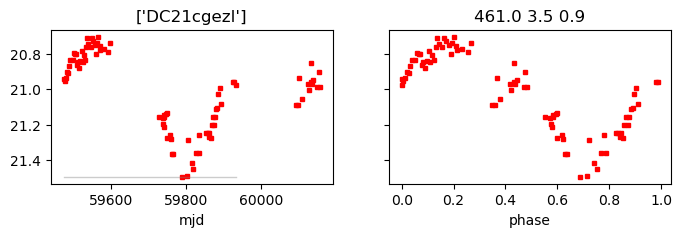

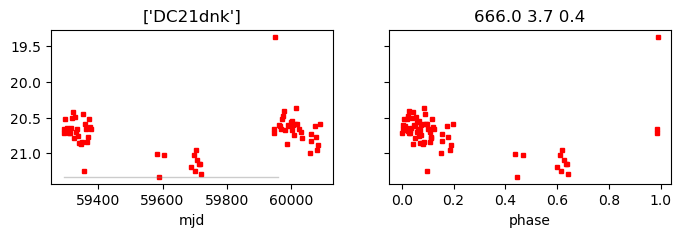

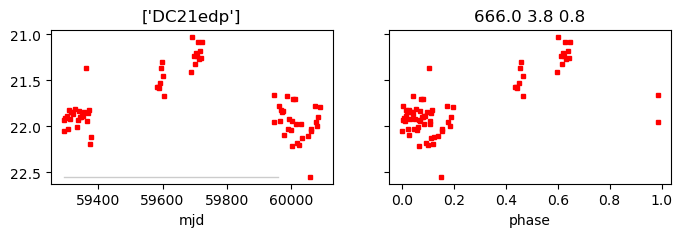

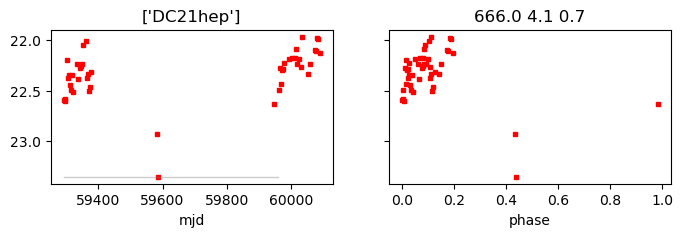

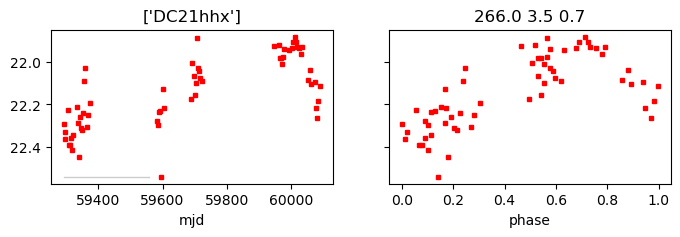

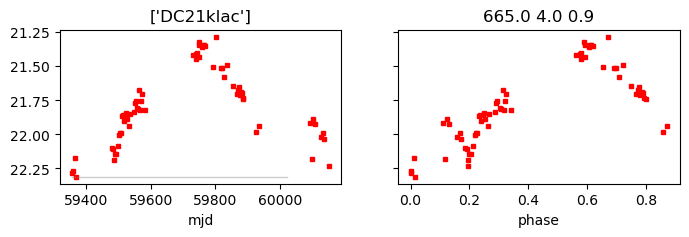

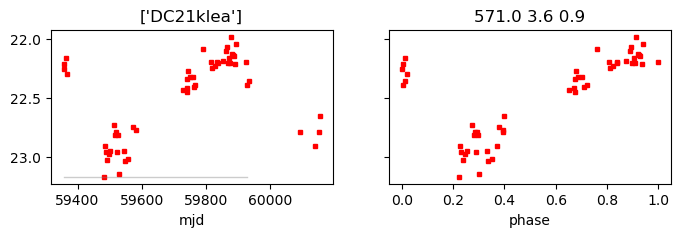

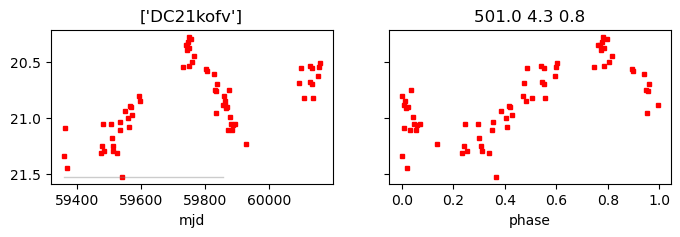

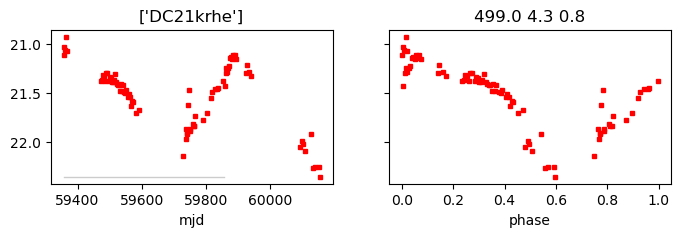

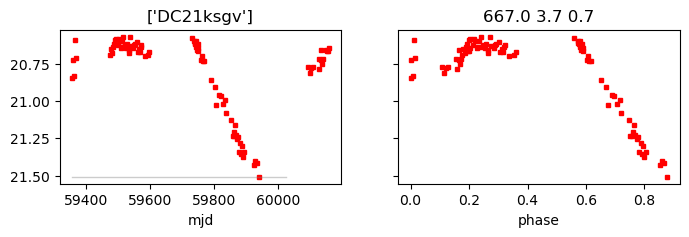

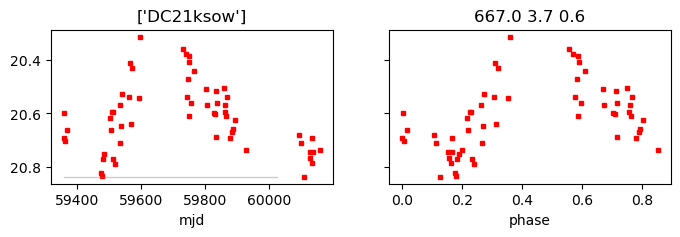

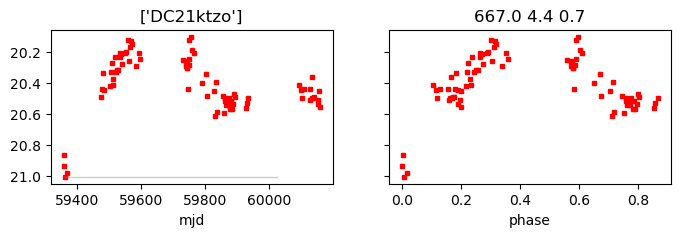

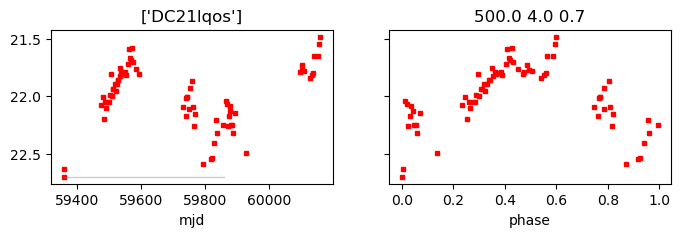

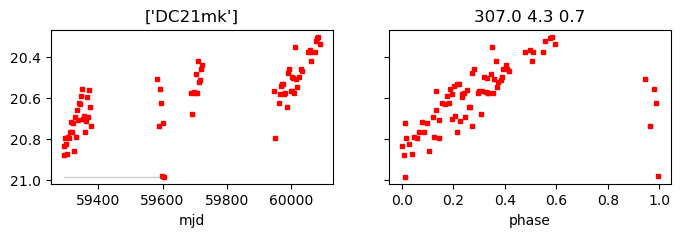

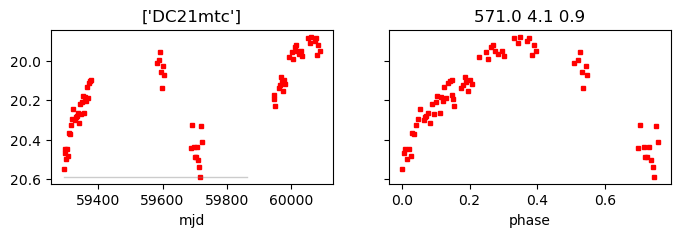

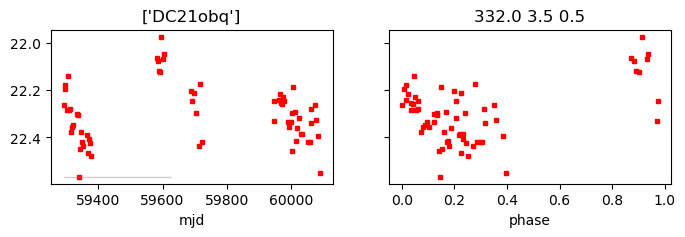

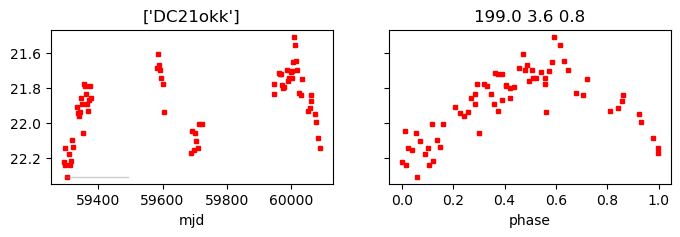

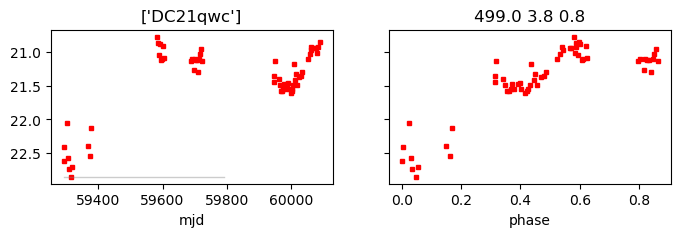

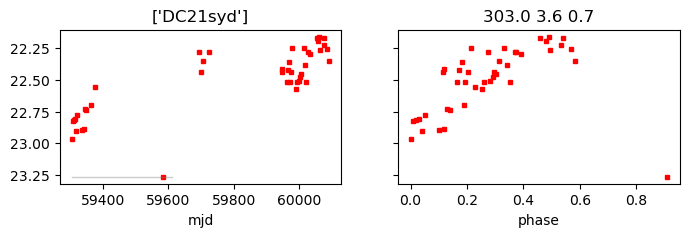

In [36]:
usefilt = 'r'
for cand in usecands:
    px = np.where(paramLC_candid == cand)[0]
    if usefilt == 'g':
        best_period = paramLC_Pbest_g[px[0]]
    if usefilt == 'r':
        best_period = paramLC_Pbest_r[px[0]]
    if usefilt == 'i':
        best_period = paramLC_Pbest_i[px[0]]
    
    cx = np.where((candLC_candid == cand) & (candLC_filter == usefilt))[0]
    days = candLC_mjd[cx]
    mags = candLC_mag[cx]

    x = np.where(all_filters == usefilt)[0]
    sym = all_fshapes[x[0]]
    clr = all_fcolors[x[0]]
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=False, sharey=True)
    
    ax[0].plot(days, mags, sym, ms=3, color=clr)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('mjd')

    t0 = np.min(days)
    days_norm = (days - t0) / best_period
    phase = np.mod(days_norm, 1.0)

    ax[1].plot(phase, mags, sym, ms=3, color=clr)
    ax[1].set_xlabel('phase')
    # ax[1].invert_yaxis()

    ax[0].plot([t0, t0+best_period], [np.max(mags), np.max(mags)], lw=1, alpha=0.4, color='grey')
    
    ax[0].set_title(paramLC_candid[px])
    tmp = ''
    if usefilt == 'g':
        tmp += str(np.round(paramLC_Pbest_g[px[0]], 0))
        tmp += ' ' + str(np.round(paramLC_Psnr_g[px[0]], 1))
        tmp += ' ' + str(np.round(paramLC_Ppwr_g[px[0]], 1))
    if usefilt == 'r':
        tmp += str(np.round(paramLC_Pbest_r[px[0]], 0))
        tmp += ' ' + str(np.round(paramLC_Psnr_r[px[0]], 1))
        tmp += ' ' + str(np.round(paramLC_Ppwr_r[px[0]], 1))
    if usefilt == 'i':
        tmp += str(np.round(paramLC_Pbest_i[px[0]], 0))
        tmp += ' ' + str(np.round(paramLC_Psnr_i[px[0]], 1))
        tmp += ' ' + str(np.round(paramLC_Ppwr_i[px[0]], 1))
    ax[1].set_title(tmp)

    del px, cx, best_period, days, mags
    del x, sym, clr
    del t0, days_norm, phase
    del tmp

### And for probably non-periodic variables

Again, but for things with long periods. I.e., NOT periodic but variable.

In [37]:
paramLC_Pbest_diffgr = np.abs(paramLC_Pbest_g - paramLC_Pbest_r)

min_pwr = 0.8
min_snr = 3.5
min_diff = 200
min_P = 700
max_P = 1100

gx = np.where((paramLC_Ppwr_g > min_pwr) & (paramLC_Psnr_g > min_snr) 
              & (paramLC_Pbest_g > min_P) & (paramLC_Pbest_g < max_P))[0]
rx = np.where((paramLC_Ppwr_r > min_pwr) & (paramLC_Psnr_r > min_snr) 
              & (paramLC_Pbest_r > min_P) & (paramLC_Pbest_r < max_P))[0]
print('Number of candidates that have well fit best periods in g OR r: ', len(gx), len(rx))
del gx, rx

print(' ')

gx = np.where((paramLC_Ppwr_g > min_pwr) & (paramLC_Psnr_g > min_snr) 
              & (paramLC_Pbest_g > min_P) & (paramLC_Pbest_g < max_P) & 
              (paramLC_Pbest_diffgr < min_diff))[0]
rx = np.where((paramLC_Ppwr_r > min_pwr) & (paramLC_Psnr_r > min_snr) 
              & (paramLC_Pbest_r > min_P) & (paramLC_Pbest_r < max_P) & 
              (paramLC_Pbest_diffgr < min_diff))[0]
print('Number of candidates that have well fit periods in g and r that match: ', len(gx), len(rx))

print(' ')

print('Candidates to explore the r-band light curves & phase-folded light curves')
print(paramLC_candid[rx])
usecands = paramLC_candid[rx]
del gx, rx

Number of candidates that have well fit best periods in g OR r:  28 51
 
Number of candidates that have well fit periods in g and r that match:  22 39
 
Candidates to explore the r-band light curves & phase-folded light curves
['DC21bhq' 'DC21blkp' 'DC21cgesc' 'DC21cgetl' 'DC21cwx' 'DC21fco'
 'DC21fqf' 'DC21gha' 'DC21gto' 'DC21ieq' 'DC21ioi' 'DC21jln' 'DC21kkuo'
 'DC21klhb' 'DC21klkb' 'DC21kmiv' 'DC21kmon' 'DC21kmpd' 'DC21kntb'
 'DC21koks' 'DC21kokv' 'DC21koqo' 'DC21kpfx' 'DC21kpih' 'DC21kpup'
 'DC21krne' 'DC21krri' 'DC21krwa' 'DC21kudp' 'DC21kvas' 'DC21kvum'
 'DC21lcvl' 'DC21ldgy' 'DC21lhq' 'DC21lnci' 'DC21nuu' 'DC21pra' 'DC21pul'
 'DC21wmq']


/tmp/ipykernel_2112945/575484421.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=False, sharey=True)


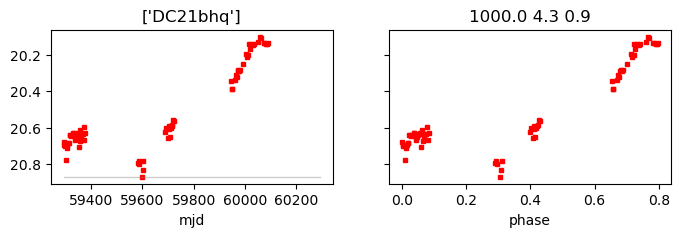

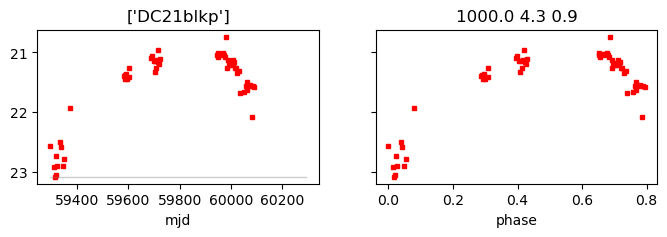

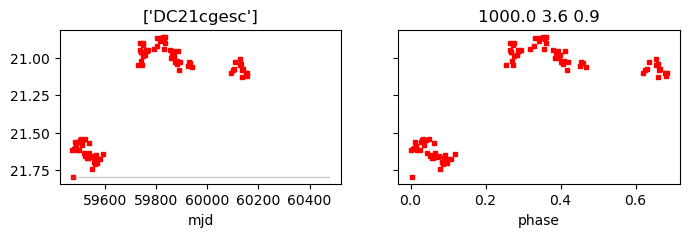

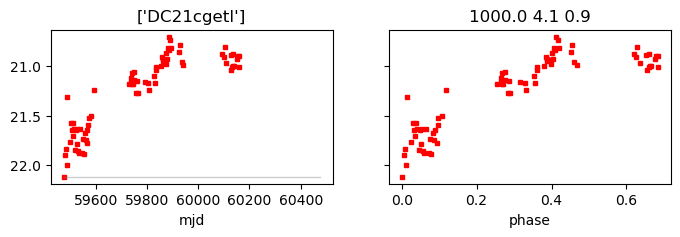

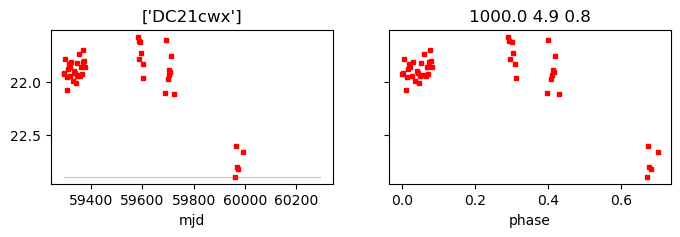

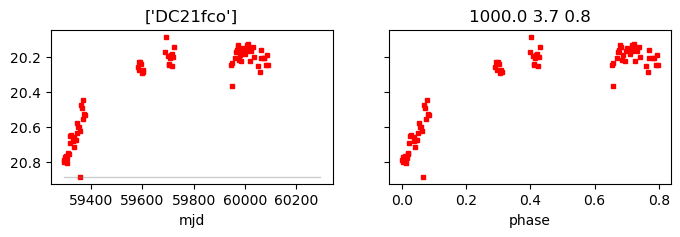

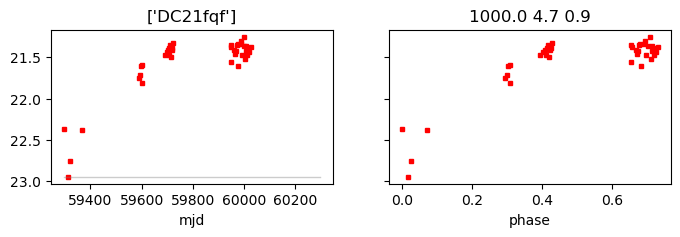

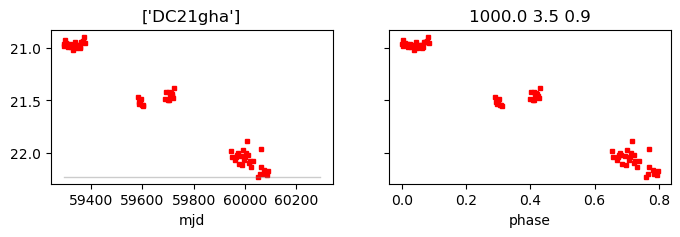

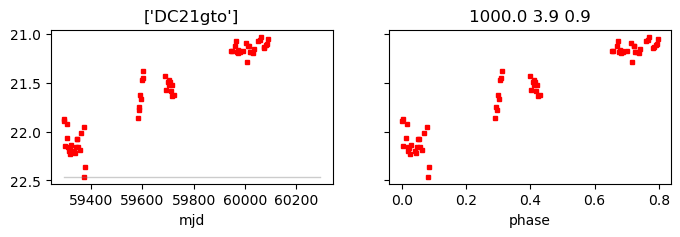

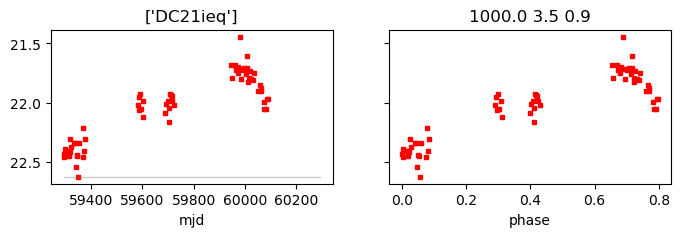

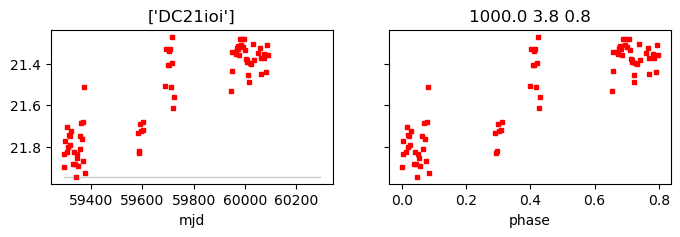

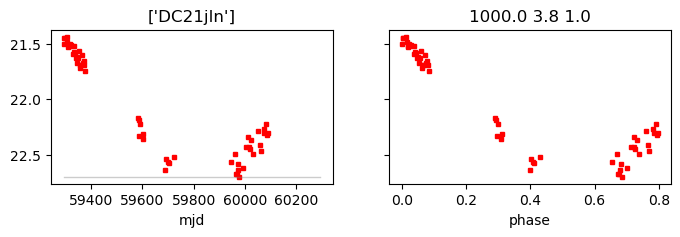

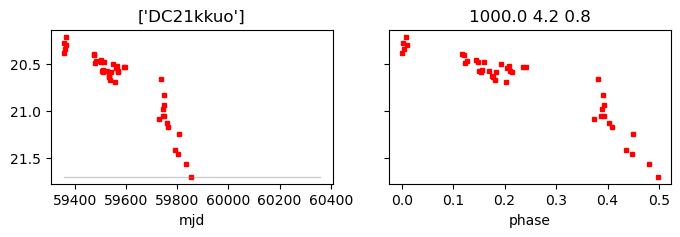

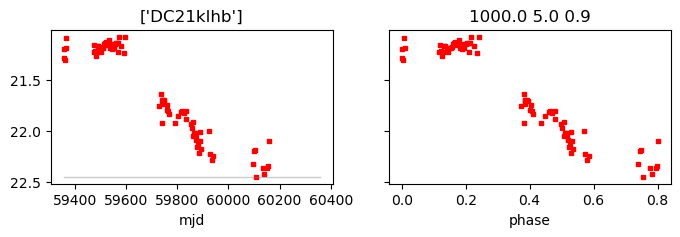

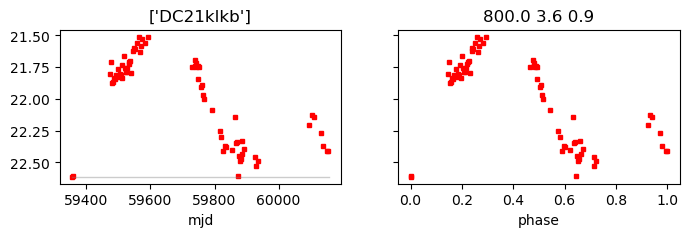

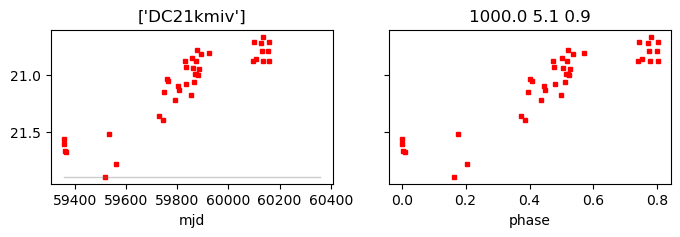

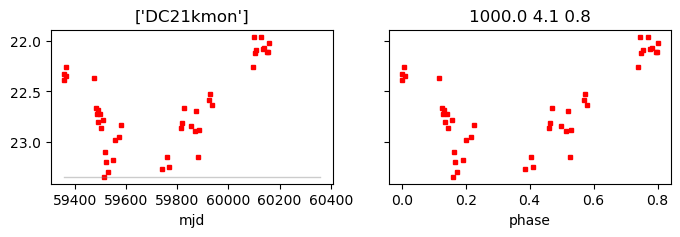

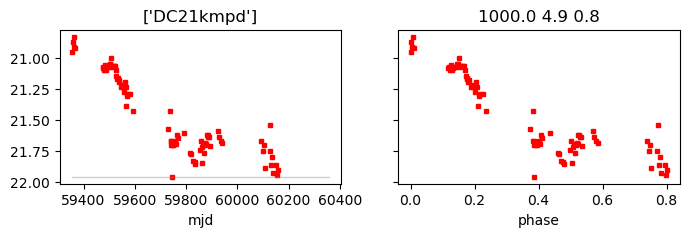

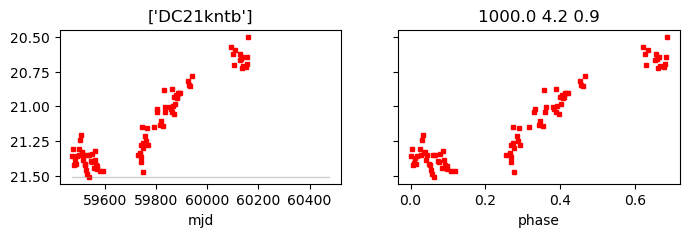

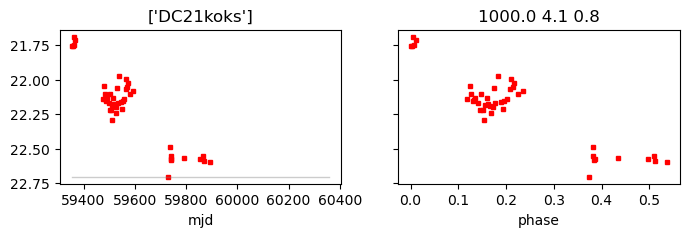

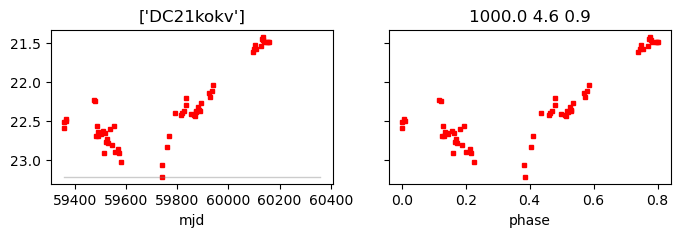

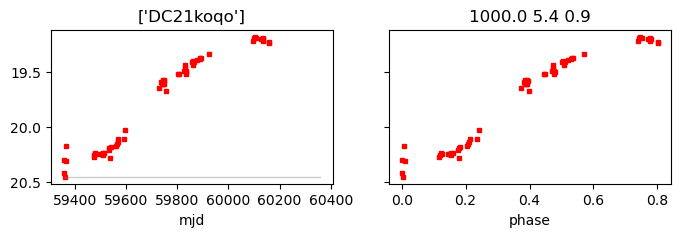

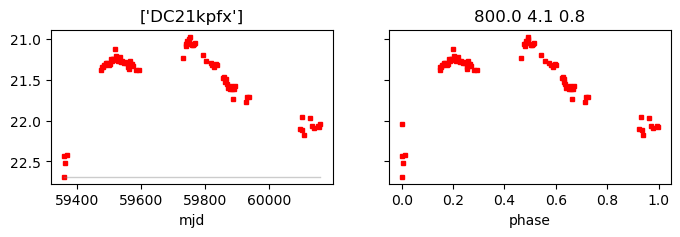

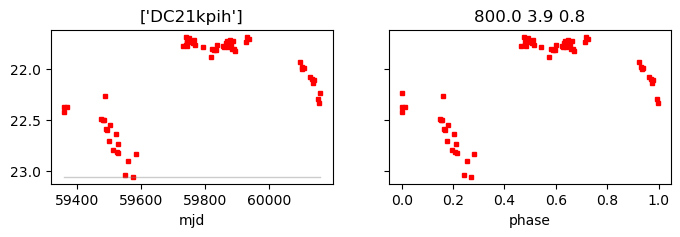

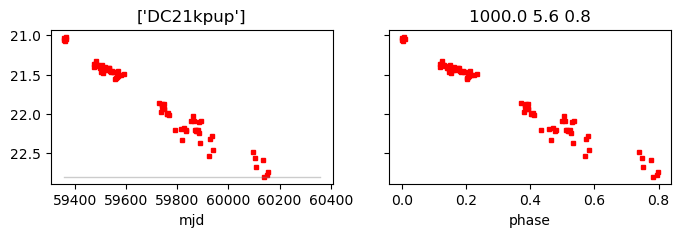

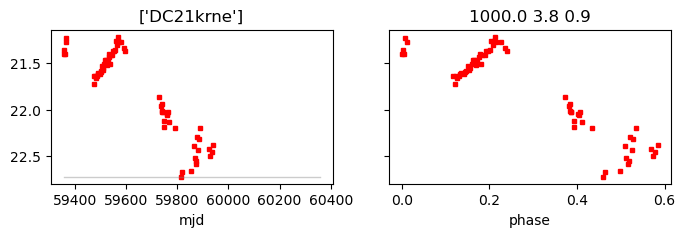

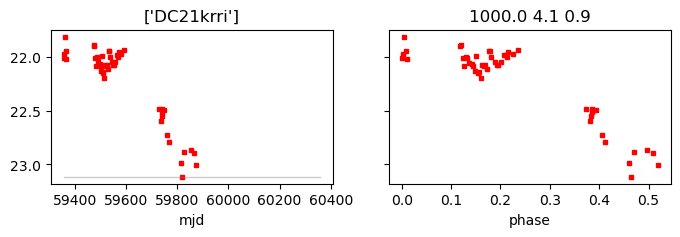

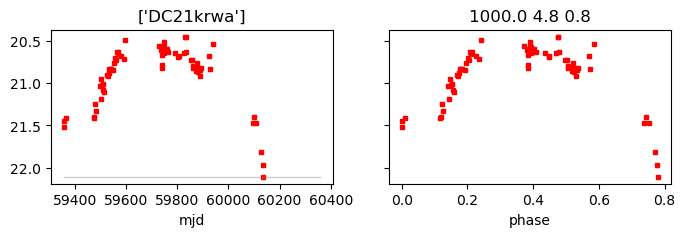

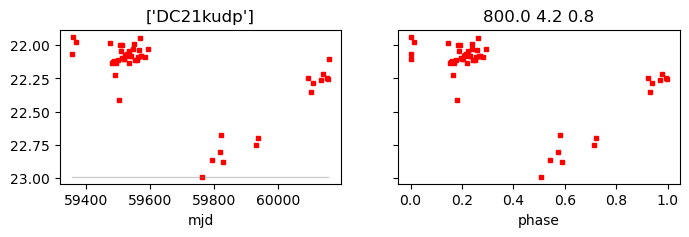

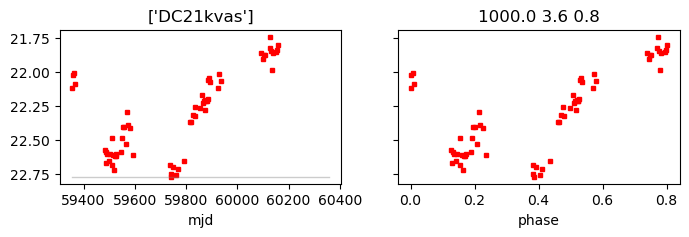

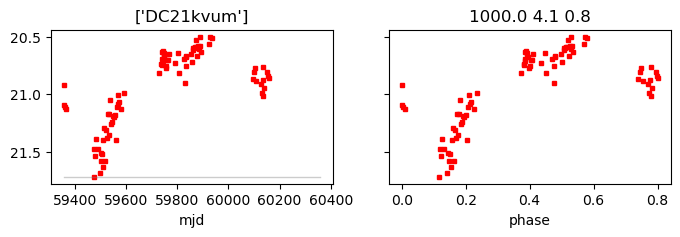

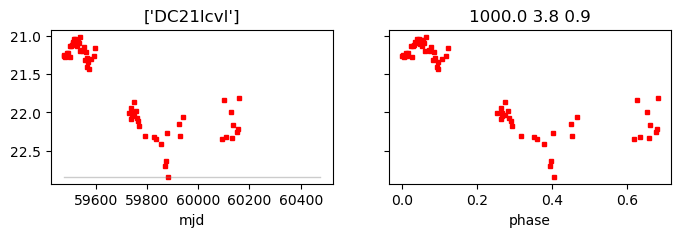

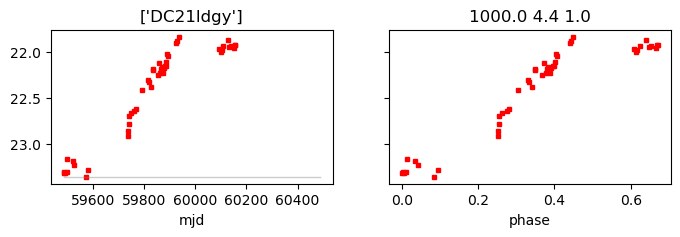

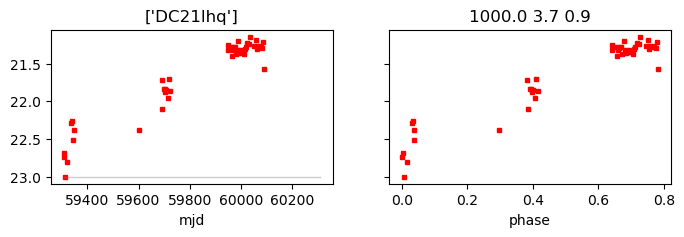

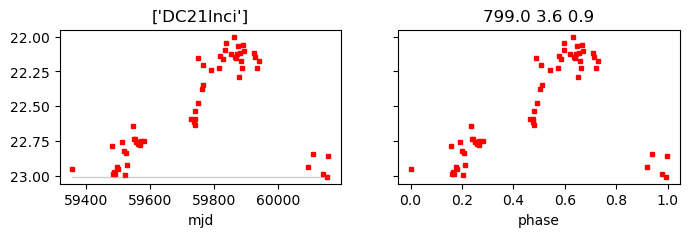

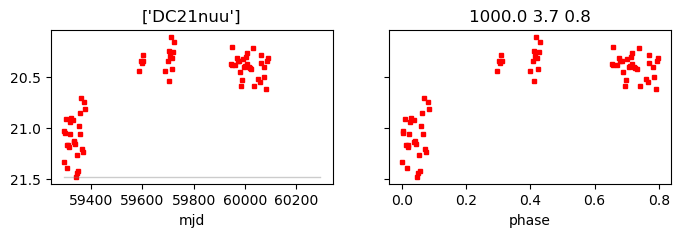

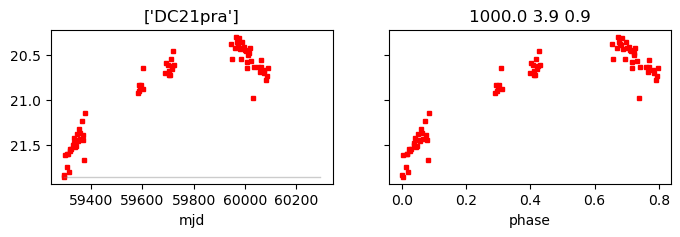

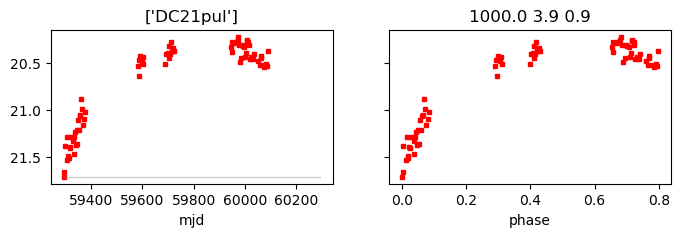

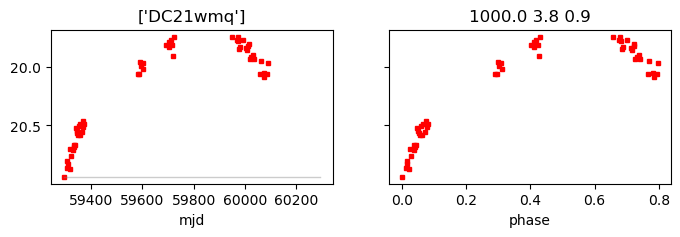

In [38]:
usefilt = 'r'
for cand in usecands:
    px = np.where(paramLC_candid == cand)[0]
    if usefilt == 'g':
        best_period = paramLC_Pbest_g[px[0]]
    if usefilt == 'r':
        best_period = paramLC_Pbest_r[px[0]]
    if usefilt == 'i':
        best_period = paramLC_Pbest_i[px[0]]
    
    cx = np.where((candLC_candid == cand) & (candLC_filter == usefilt))[0]
    days = candLC_mjd[cx]
    mags = candLC_mag[cx]

    x = np.where(all_filters == usefilt)[0]
    sym = all_fshapes[x[0]]
    clr = all_fcolors[x[0]]
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=False, sharey=True)
    
    ax[0].plot(days, mags, sym, ms=3, color=clr)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('mjd')

    t0 = np.min(days)
    days_norm = (days - t0) / best_period
    phase = np.mod(days_norm, 1.0)

    ax[1].plot(phase, mags, sym, ms=3, color=clr)
    ax[1].set_xlabel('phase')
    # ax[1].invert_yaxis()

    ax[0].plot([t0, t0+best_period], [np.max(mags), np.max(mags)], lw=1, alpha=0.4, color='grey')
    
    ax[0].set_title(paramLC_candid[px])
    tmp = ''
    if usefilt == 'g':
        tmp += str(np.round(paramLC_Pbest_g[px[0]], 0))
        tmp += ' ' + str(np.round(paramLC_Psnr_g[px[0]], 1))
        tmp += ' ' + str(np.round(paramLC_Ppwr_g[px[0]], 1))
    if usefilt == 'r':
        tmp += str(np.round(paramLC_Pbest_r[px[0]], 0))
        tmp += ' ' + str(np.round(paramLC_Psnr_r[px[0]], 1))
        tmp += ' ' + str(np.round(paramLC_Ppwr_r[px[0]], 1))
    if usefilt == 'i':
        tmp += str(np.round(paramLC_Pbest_i[px[0]], 0))
        tmp += ' ' + str(np.round(paramLC_Psnr_i[px[0]], 1))
        tmp += ' ' + str(np.round(paramLC_Ppwr_i[px[0]], 1))
    ax[1].set_title(tmp)

    del px, cx, best_period, days, mags
    del x, sym, clr
    del t0, days_norm, phase
    del tmp

### Figures for the paper

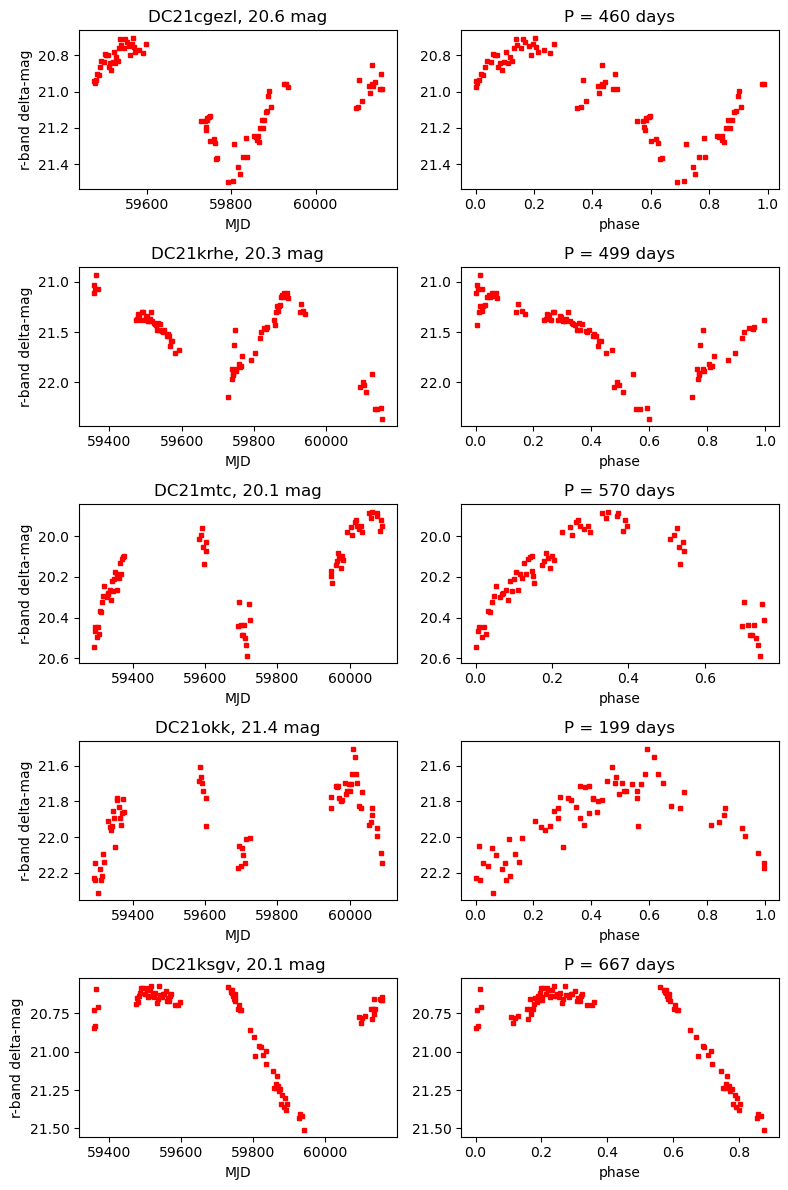

In [39]:
usecands = ['DC21cgezl', 'DC21krhe', 'DC21mtc', 'DC21okk', 'DC21ksgv']
usefilt = 'r'

fig, ax = plt.subplots(5, 2, figsize=(8, 12), sharex=False, sharey=False)

for c, cand in enumerate(usecands):
    xx = np.where(lsdr10xm_candid == cand)[0]
    px = np.where(paramLC_candid == cand)[0]
    best_period = paramLC_Pbest_r[px[0]]
    
    cx = np.where((candLC_candid == cand) & (candLC_filter == usefilt))[0]
    days = candLC_mjd[cx]
    mags = candLC_mag[cx]

    x = np.where(all_filters == usefilt)[0]
    sym = all_fshapes[x[0]]
    clr = all_fcolors[x[0]]
        
    ax[c, 0].plot(days, mags, sym, ms=3, color=clr)
    ax[c, 0].invert_yaxis()
    ax[c, 0].set_xlabel('MJD')
    ax[c, 0].set_ylabel('r-band delta-mag')

    t0 = np.min(days)
    days_norm = (days - t0) / best_period
    phase = np.mod(days_norm, 1.0)

    ax[c, 1].plot(phase, mags, sym, ms=3, color=clr)
    ax[c, 1].set_xlabel('phase')
    ax[c, 1].invert_yaxis()
  
    tmp = cand + ', ' + str(np.round(lsdr10xm_rmag[xx[0]], 1))+ ' mag'
    ax[c, 0].set_title(tmp)
    del tmp

    tmp = 'P = %3i days' % paramLC_Pbest_r[px[0]]
    # tmp += ' ' + str(np.round(paramLC_Psnr_r[px[0]], 1))
    # tmp += ' ' + str(np.round(paramLC_Ppwr_r[px[0]], 1))
    ax[c, 1].set_title(tmp)
    del tmp
    
    del px, cx, best_period, days, mags
    del x, sym, clr
    del t0, days_norm, phase
    
plt.tight_layout()
plt.savefig('plots/stellar_1')
plt.show()